# Muon Lifetime Lab
### Miles Lucas - Phys 322L - Iowa State University

This lab seeks to find the mean life of cosmic muons incident on Earth's surface. Theoretically, this relationship can be represented by 
$$
N(t) = N = N_0 e^{-k\cdot t}
$$

The mean life of the muon is $\tau_0 = 1 / k$ where $k$ can be found via the following data analysis

In [11]:
# Imports and parameter setting

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn')
params = {
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'figure.figsize':(6, 6),
    'figure.dpi':100,
    'axes.labelsize':16,
    'legend.fontsize':14
}
mpl.rcParams.update(params)

## Calibration Data

Because all of our timed data is binned by the signal interface into channels, we had to find the relationship between bin number and time. Using a delay module, we introduced known delays and correlated them to bin number. The following data finds a linear fit so that we can find the time interval associated with every channel for later analysis

In [13]:
try:
    calib = pd.read_csv('calib.csv', header=0, names=['Interval', 'Channel'])
except FileNotFoundError:
    print('Calibration file not found')

In [15]:
res = smf.ols('Interval ~ Channel', data=calib).fit()
print(res.summary())
res.params
b, a = res.params
f = lambda c: a * c + b

                            OLS Regression Results                            
Dep. Variable:               Interval   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.639e+04
Date:                Sun, 23 Apr 2017   Prob (F-statistic):           3.09e-26
Time:                        18:14:30   Log-Likelihood:                 43.574
No. Observations:                  15   AIC:                            -83.15
Df Residuals:                      13   BIC:                            -81.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.1182      0.008    -14.617      0.0

C:\Users\drumm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


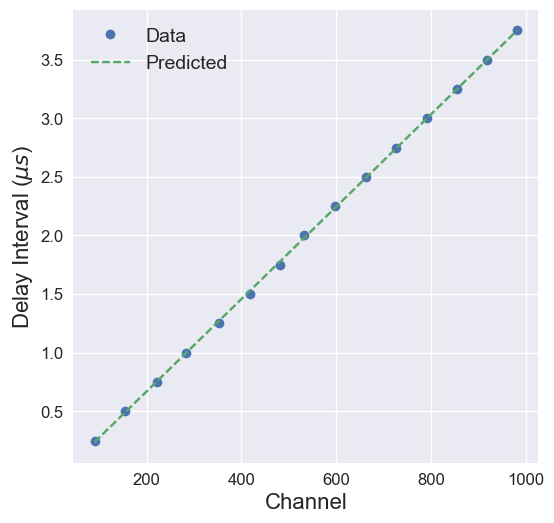

In [16]:
plt.xlabel('Channel')
plt.ylabel('Delay Interval ($\mu s$)')

plt.plot(calib['Channel'], calib['Interval'], 'o', label='Data')
plt.plot(calib['Channel'], res.fittedvalues, '--', label='Predicted')
plt.legend(loc='best');
plt.savefig('calib.png', bbox_inches='tight')

## Applying to data

Now that we know the time intervals for each channel, we import our data and look at the relationship between counts and time. This ought to be an exponential relationship from our theoretical model. However, it is much more accurate to use a linear fit for our analysis, as non-linear fits can be very erratic. Our model is easy to linearize, though. Our model can be transformed into this linear model
$$
ln(N) = ln(N_0 e^{-k t}) = -kt + ln(N_0)
$$
When we do a linear fit for this model, we see that our slope is $-k$, and the intercept is $ln(N_0)$. 

One problem with our data, though, is that there are many counts of 0, which have no logarithmic value. To combat this, we do two things. First, we remove all the zeros at the head of the dataset, which is okay because a pure exponential decay will naturally start at its highest value and won't ramp up from some value. Second, we apply an exponentially-weighted moving average. This allows the zero-counts at the tail of the data to affect our fit (as opposed to just remove all 0-count entries) without running into issues with finding the logarithm of 0.

In [18]:
try:
    test_data = pd.read_csv('Exp3_Tue_4day_RUN2.csv', header=0)
except FileNotFoundError:
    print('Data file not found')

# Get first non-zero count, start data series from here
nzi = next((i for i, x in enumerate(test_data['Counts']) if x), None)
test_data = test_data[(test_data.index > nzi)]
test_data['Time'] = f(test_data['Channel'])

# Get an exponential moving average to allow linearization of 0 values
test_data['ewma'] = test_data['Counts'].ewm(span=max(test_data['Time'])).mean()

In [19]:
res2 = smf.ols(formula='np.log(ewma) ~ Time', data=test_data).fit()
print(res2.summary())

A, k = res2.params
A = np.exp(A)
c = -1/k
f = lambda t: A * np.exp(k * t)

                            OLS Regression Results                            
Dep. Variable:           np.log(ewma)   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 1.176e+04
Date:                Sun, 23 Apr 2017   Prob (F-statistic):               0.00
Time:                        18:22:16   Log-Likelihood:                -1232.6
No. Observations:                2010   AIC:                             2469.
Df Residuals:                    2008   BIC:                             2480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.3955      0.020    119.466      0.0

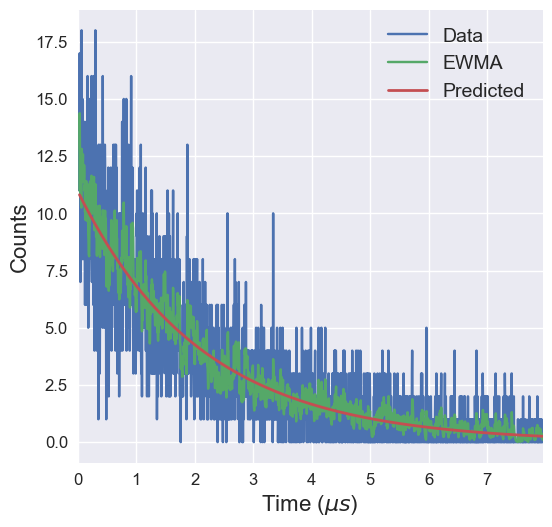

In [20]:
ax = plt.gca()
ax.set_xlim(0, max(test_data['Time']))
ax.set_xlabel('Time ($\mu s$)')
ax.set_ylabel('Counts')

plt.plot(test_data['Time'], test_data['Counts'], label='Data')
plt.plot(test_data['Time'], test_data['ewma'], label='EWMA')
plt.plot(test_data['Time'], f(test_data['Time']), linewidth=2.0, label='Predicted')
ax.legend(loc='best')

plt.savefig('data_fit.png', bbox_inches='tight')

In [21]:
actual = 2.22
error = np.abs(actual - c) / actual * 100
print('Time constant fit value: {}\nTime constant actual value: {}\nError: {}%'.format(c, actual, error))

Time constant fit value: 2.11432536611756
Time constant actual value: 2.22
Error: 4.760118643353168%
